# <span style="color:blue">Quant Final Project</span>
## Finance 372 - Prof Travis Johnson

## Solution by: <span style="color:orange">Trent Becker, Arjun Nair, Madhavan Uchani </span>

In [106]:
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path

In [107]:
# Solution
# signal_df = pd.read_stata("final_project_data.dta")
#TODO --> Determine if we need the foreign identifier code from compustat data or if we can justify not needing it
df = pd.read_csv("crsp_finalproject.csv", dtype={'PERMNO': 'str', 'date': 'str', 'TICKER': 'str', 'COMNAM': 'str', 'PRC': 'float', 'VOL': 'float', 'RET': 'str', 'SHROUT': 'float'})
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df['RET'] = df['RET'].astype(float)
df = df[df['date'] >= '1983-06-01']

Now remove unnecessary columns, keeping only gvkey, datadate, at, cogs, and revt. Write the edited dataframe into a .dta file using `.to_stata('gp_data.dta',write_index=False)`

In [161]:
# Solution
#signal_df = signal_df[['PERMNO', 'date', 'TICKER', 'COMNAM', 'PRC', 'VOL', 'RET', 'SHROUT']]
#signal_df.to_stata('index_rebalancing_data.dta', write_index=False)
df1985 = df[(pd.to_datetime(df['date']).dt.year > 1989) & (pd.to_datetime(df['date']).dt.year < 1992)]
df1985.to_csv("1991data.csv")

Run this cell without editing it to show us what your signal_df looks like:

In [109]:
# print(signal_df.sort_values(by='date'))
temp_df = df[df['date'] == '1984-04-30']
temp_df

,PERMNO,date,TICKER,COMNAM,PRC,VOL,RET,SHROUT
1079,10006,1984-04-30,ACF,A C F INDUSTRIES INC,52.6250,19428.0,0.031863,8385.0
1936,10015,1984-04-30,AMFD,A & M FOOD SERVICES INC,-7.2500,1362.0,0.104762,3568.0
4175,10031,1984-04-30,ANTQ,A A IMPORTING INC,-4.3125,203.0,-0.178571,2683.0
8015,10057,1984-04-30,AMT,ACME CLEVELAND CORP,21.0000,2576.0,0.004762,6106.0
8300,10058,1984-04-30,ABKC,A B K C O INDUSTRIES INC,-0.6875,6.0,-0.083333,1089.0
...,...,...,...,...,...,...,...,...
4018028,90705,1984-04-30,OPTC,OPTELECOM INC,-4.6875,1318.0,-0.157303,3025.0
4051671,90975,1984-04-30,PEOP,PEOPLES BAN CORP,-25.2500,834.0,0.052083,3782.0
4206531,92321,1984-04-30,NaN,TAURUS OIL CORP,NaN,NaN,NaN,15639.0
4274787,92946,1984-04-30,VYQT,VYQUEST INC,-5.3125,360.0,-0.086022,3837.0


Copy and modify the BMDataProcessor to create a IRDataProcessor class. It should load the same `price_df` as before (from the monthly_returns.csv file) but a new `signal_df` with revt, cogs, and lag_at columns (in addition to the date and security_id columns). The lag_at column should contain the prior year's at value, which you can get using the included  `safe_lead_lag` method

Let's be very conservative and say we can't rely on having accounting data until 120 days after the end of the fiscal year ('datadate' column). Assume we are willing to use accounting data up to two years old.

***HINT***: be sure to change the `data_folder_path`, `min_accounting_lag`, `max_accounting_lag`, and the constructor `__init__(self)` to reflect the new strategy. The `unique_dates()` and `signal_df_for_date` functions only need to be updated to use datatdate instead of rdq (since we don't have an rdq column in this annual data). These functions will otherwise work as-is, and the other functions don't need to be changed at all.

In [110]:
# Solution
class IRDataProcessor():
    
    # Path to where we store the data
    data_folder_path = Path('') 
    # Minimum share price to open a new position
    min_share_price = 3.0
    
    # Constructor, loads/cleans/merges data as needed
    def __init__(self):
        
        # Load price data: monthly 1961-2020 sample from CRSP including all public US equities
        # In monthly_returns.csv
#         self.price_df = pd.read_csv(self.data_folder_path / 'monthly_returns.csv')
        
        # Parse the yyyyMMdd int dates into DateTime64
        # Based on formatting strings here
        # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
#         self.price_df.loc[:,'date'] = pd.to_datetime(self.price_df.loc[:,'date'], format ="%Y%m%d")
        
        # Prices sometimes negative to indicate no volume at closing auction
        # In these cases, price = -0.5*(bid+ask)
        # But we don't use that information and so want prices to always be positive
        # See http://www.crsp.org/products/documentation/data-definitions-p
#         self.price_df.loc[:,'prccm'] = np.absolute(self.price_df.loc[:,'prccm'])
        
        # Add next-months return as a new column 'ret_next'
        # Use the safe_lead_lag: want lead return but only when permno the same
        # self.price_df.loc[:,'ret_next'] = safe_lead_lag(self.price_df.loc[:,'ret'],self.price_df.loc[:,'permno'],1)
        
#         self.price_df = self.price_df.dropna()
#         self.price_df['market_cap'] = self.price_df['prccm'] * self.price_df['cshom']

        # Load accounting data used for BM signal
        # Quarterly sample from 1961-2020 from Compustat Fundamentals Quarterly
        # Stored in the `comp_bm.dta` file
        # `.dta` files are Stata data, and do a better job than `.csv` files of remembering data types
        self.signal_df = pd.read_csv("crsp_finalproject.csv", dtype={'PERMNO': 'str', 'date': 'str', 'TICKER': 'str', 'COMNAM': 'str', 'PRC': 'float', 'VOL': 'float', 'RET': 'str', 'SHROUT': 'float'})
        self.signal_df = self.signal_df[self.signal_df['date'] >= '1983-06-28']
        self.signal_df['RET'] = pd.to_numeric(self.signal_df['RET'], errors='coerce')
        self.signal_df['RET'] = self.signal_df['RET'].astype(float)        
#         self.signal_df.loc[:, 'lag_at'] = safe_lead_lag(self.signal_df.loc[:, 'at'], self.signal_df.loc[:,'gvkey'], -1)
#         self.signal_df.drop('at', axis=1, inplace=True)

        self.signal_df['date'] = pd.to_datetime(self.signal_df['date'])
        self.signal_df['month'] = pd.DatetimeIndex(self.signal_df['date']).month
        self.signal_df['day'] = pd.DatetimeIndex(self.signal_df['date']).day
        self.signal_df['year'] = pd.DatetimeIndex(self.signal_df['date']).year
        self.signal_df.loc[self.signal_df['month'] == 4, "day"] = 30
        self.signal_df.loc[self.signal_df['month'] == 6, "day"] = 30
        import calendar
        self.signal_df['date'] = self.signal_df['date'].apply(lambda dt: dt.replace(day=min(calendar.monthrange(dt.year, dt.month)[1],30)))
        self.signal_df['PRC'] = self.signal_df['PRC'].abs()
        # self.signal_df['date'] = pd.to_datetime(dict(year=self.signal_df.year, month=self.signal_df.month, day=self.signal_df.day))
        self.signal_df['market_cap'] = self.signal_df['PRC'] * self.signal_df['SHROUT']
        # self.signal_df['ret_next'] = safe_lead_lag(self.signal_df.loc[:,'RET'],self.signal_df.loc[:,'PERMNO'],12)
        self.signal_df = self.signal_df.dropna()
        
        #TODO explain why these dates were selected based on Russell 2000 schedule
        prediction_date = '04/30'
        last_rebalance = '06/30'
        self.signal_df = self.liquidity_filter(self.signal_df)
        self.prediction_date = dt.datetime.strptime(prediction_date, '%m/%d')
        self.last_rebalance = dt.datetime.strptime(last_rebalance, '%m/%d')

        # The problem with our accounting data is that it identifies stocks using gvkey instead of permno
        # To merge with return_df, we need to use another dataset that converts gvkey to permno
        # This is stored in the gvkey_permno_conversion.dta file
#         self.gvkey_permno_conversion = pd.read_stata(self.data_folder_path / 'gvkey_permno_conversion.dta')

        # Use a merge command to add the permno column to our signal_df
#         self.signal_df = self.signal_df.merge(self.gvkey_permno_conversion,on=['gvkey','datadate'])           
        
    # Returns an array with the unique dates for which we have loaded data
    # Uses from the price_df since that's how frequency we can update portfolio value
    # Filters all dates in price_df to return only dates for which we have signals as well
    def unique_dates(self):
        temp_df = self.signal_df
        # temp_df['date'] = temp_df['date'].apply(lambda dt: dt.replace(day=30) if ((dt.month == 4) | (dt.month == 6)) else dt)
        price_dates = pd.Series( np.sort(self.signal_df.loc[:,'date'].unique()) )
        return price_dates    
    # Returns a DataFrame containing one row for all securities in price_df as of date.
    # Columns must include:
    # - 'date': date on which price data observed
    # - 'security_id': a security identifier
    # - 'prc': price on date
    # - 'ret': return from previous date to date
    # Ignores liquidity and future-return availability requirements
    # To be used only for closing decisions and execution decisions
    # Some of the returned stocks cannot be traded
    def price_df_for_date(self,date):
        price_date_df = self.signal_df.loc[ self.signal_df.loc[:,'date'] == date, :]
        return price_date_df.rename(columns={'PERMNO':'security_id'}) 
    
    # Returns a DataFrame where each row is a security in the strategy's universe,
    # Columes must include:
    # - 'date': date on which price data observed
    # - 'security_id': a security identifier
    # - whatever signals the trading rule needs to decide which securities to open new positions in
    #   - In this case, return cshoq, prccq, and ceqq so trading rule can compute B/M ratio
    #
    # Also responsible for applying whatever liquidity filters are wanted to narrow universe,
    # and check that we have future return data (no point in backtesting if we don't know what happens next)
    def signal_df_for_date(self,date):
        temp_df1 = self.signal_df
        # temp_df1 = self.date_filter(temp_df1, self.prediction_date.month, self.last_rebalance.month)
        # temp_df1['date'] = temp_df1['date'].apply(lambda dt: dt.replace(day=30))
        # temp_df1.to_csv("temp_df1_1985.csv")
        date_price_df = temp_df1.loc[ temp_df1.loc[:,'date'] == date,:]
        date_price_df.rename(columns={'PERMNO':'security_id', 'PRC': 'prc', 'RET': 'ret'}, inplace=True)  # use permno as our security_id        
        # and return without the ret_next column so backtests don't cheat by using it
        return date_price_df
    
    def filter_and_rank(self,df):
        #TODO commenting out for now because I think CRSP may only be US data and we could justify that but not sure
        # filtered_df = self.country_filter(self.signal_df)
        filtered_df = self.date_filter(df, self.prediction_date.month,self.last_rebalance.month)
        # filtered_df = filtered_df.loc[ np.isfinite(filtered_df.loc[:,'ret_next']),:]
        # filtered_df = filtered_df.drop(columns=['ret_next'])
  
        # TODO: May need to change this since dropping NaN gets rid of too many rows
        filtered_df = filtered_df[filtered_df['market_cap'].notna()]
        filtered_df.rename(columns={'PERMNO':'security_id', 'PRC': 'prc', 'RET': 'ret'}, inplace=True)  # use permno as our security_id        
        filtered_df = self.rank_by_market_cap(filtered_df)
        # ranking process
        return filtered_df
    

    # Returns a filterd version of the passed DataFrame,
    # with all observations deemefd too illiquid removed
    # Liquidity requirements:
    #  - price >= $3
    def liquidity_filter(self,df):
        return df.loc[ df.loc[:,'PRC'] >= self.min_share_price,:]

    

    def country_filter(self, df):
        return df.loc[df.loc[:, 'fic'] == 'USA',:]

    

    def date_filter(self, df, prediction_month, rebalance_month): 
        condition1 = ((df['month'] == prediction_month))
        condition2 = ((df['month'] == rebalance_month))
        return df.loc[(condition1 | condition2),:]
    
    
    def rank_by_market_cap(self, df):
        df['rank'] = df.groupby(['date'])['market_cap'].rank(ascending=False, method='first')
        return df 

        
        
###################################################################
# Helper methods, do not modify
###################################################################

# Function safe_lead_lag returns a new Series with the lead/lagged values
#  but only when a group is the same for the lead/lag
# Inputs:
# - data_series: data we want to lead/lag
# - group_series: grouping we want to be the same for the lead/lag to be value
# requires data_series and group_series already by sorted by group_series
# so that all alike values of group_series are adjacent,
# meaning group_series should look like:
#    g_0
#    g_0
#    g_0
#    g_0
#    g_1
#    g_1
#    g_2
#    g_2 
#    ...
# where g_i indicates the observation is in group i,
# and once the first g_{i+1} appears no more g_i values appear
# 
# lead_lag > 0 returns a data_series with values of data_series lead_lag rows ahead
# as long as group_series remains the same, NaN if group different
# lead_lag < 0 returns a data_series with values of data_series -lead_lag rows behind 
# (same as lead_lag rows ahead) as long as group_series remains the same, NaN if group different
def safe_lead_lag(data_series,group_series,lead_lag): 
    df = pd.DataFrame({ 'data': data_series, 'group': group_series })
    return df.groupby(['group'])['data'].shift(-lead_lag)

In [111]:
temp_processor = IRDataProcessor()
temp_df = temp_processor.signal_df
temp_df = temp_processor.filter_and_rank(temp_df)
temp_df

## VERIFIED FINE BY THIS POINT

KeyboardInterrupt: 

### After running your code above, you should be able to run these tests sucessfully. Please run each cell without editing.

#### Constructor tests: should print price_df and signal_df.

In [ ]:
data_processor = IRDataProcessor()
print('\n\n', data_processor.signal_df)



         PERMNO       date TICKER                     COMNAM        PRC  \
2        10000 1986-02-28  OMFGA  OPTIMUM MANUFACTURING INC    3.25000   
3        10000 1986-03-30  OMFGA  OPTIMUM MANUFACTURING INC    4.43750   
4        10000 1986-04-30  OMFGA  OPTIMUM MANUFACTURING INC    4.00000   
5        10000 1986-05-30  OMFGA  OPTIMUM MANUFACTURING INC    3.10938   
6        10000 1986-06-30  OMFGA  OPTIMUM MANUFACTURING INC    3.09375   
...        ...        ...    ...                        ...        ...   
4325383  93436 2022-08-30   TSLA                  TESLA INC  275.60999   
4325384  93436 2022-09-30   TSLA                  TESLA INC  265.25000   
4325385  93436 2022-10-30   TSLA                  TESLA INC  227.53999   
4325386  93436 2022-11-30   TSLA                  TESLA INC  194.70000   
4325387  93436 2022-12-30   TSLA                  TESLA INC  123.18000   

                VOL       RET     SHROUT  month  day  year    market_cap  
2             828.0 -0.257143    

#### `ranking_df` test: should return DataFrame with market_cap field ranked by decreasing order on specific dates (4/30 and 6/30)

In [ ]:
ranked_df = data_processor.filter_and_rank(data_processor.signal_df)
ranked_df

,security_id,date,TICKER,COMNAM,prc,VOL,ret,SHROUT,month,day,year,market_cap,rank
4,10000,1986-04-30,OMFGA,OPTIMUM MANUFACTURING INC,4.00000,957.0,-0.098592,3793.0,4,30,1986,1.517200e+04,4273.0
6,10000,1986-06-30,OMFGA,OPTIMUM MANUFACTURING INC,3.09375,1069.0,-0.005025,3793.0,6,30,1986,1.173459e+04,4562.0
23,10001,1986-04-30,GFGC,GREAT FALLS GAS CO,6.37500,225.0,0.009901,985.0,4,30,1986,6.279375e+03,4811.0
25,10001,1986-06-30,GFGC,GREAT FALLS GAS CO,6.12500,238.0,-0.013069,985.0,6,30,1986,6.033125e+03,4932.0
35,10001,1987-04-30,GFGC,GREAT FALLS GAS CO,6.12500,188.0,-0.039216,991.0,4,30,1987,6.069875e+03,5286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4325357,93436,2020-06-30,TSLA,TESLA INC,1079.81006,2551787.0,0.293186,186000.0,6,30,2020,2.008447e+08,26.0
4325367,93436,2021-04-30,TSLA,TESLA INC,709.44000,6774422.0,0.062147,963330.0,4,30,2021,6.834248e+08,7.0
4325369,93436,2021-06-30,TSLA,TESLA INC,679.70001,5186813.0,0.087137,984003.0,6,30,2021,6.688268e+08,7.0
4325379,93436,2022-04-30,TSLA,TESLA INC,870.76001,5046142.0,-0.191945,1036010.0,4,30,2022,9.021161e+08,4.0


#### Try it for a specific date to prove values are sorted/ranked correctly.

In [ ]:
# Prove it works for a specific date - look at 'rank' column
test_ranked_df = ranked_df.sort_values(by=['market_cap', 'date'], ascending = False)
test_ranked_df = test_ranked_df.loc[(test_ranked_df['date'] == '1998-06-30')]
test_ranked_df

,security_id,date,TICKER,COMNAM,prc,VOL,ret,SHROUT,month,day,year,market_cap,rank
255320,12060,1998-06-30,GE,GENERAL ELECTRIC CO,90.875,924414.0,0.089955,3258022.0,6,30,1998,2.960727e+08,1.0
14940,10107,1998-06-30,MSFT,MICROSOFT CORP,108.375,3106879.0,0.277819,2484636.0,6,30,1998,2.692724e+08,2.0
161620,11308,1998-06-30,KO,COCA COLA CO,85.500,699553.0,0.092823,2469341.0,6,30,1998,2.111287e+08,3.0
230220,11850,1998-06-30,XON,EXXON CORP,71.375,682701.0,0.012411,2446791.0,6,30,1998,1.746397e+08,4.0
934138,22752,1998-06-30,MRK,MERCK & CO INC,133.750,612706.0,0.147009,1195259.0,6,30,1998,1.598659e+08,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190671,81782,1998-06-30,TI,TELECOM ITALIA SPA,48.000,0.0,-0.092056,19.0,6,30,1998,9.120000e+02,7701.0
1106235,28303,1998-06-30,DAIEY,DAI EI INC,4.250,58.0,-0.313131,151.0,6,30,1998,6.417500e+02,7702.0
3353243,83923,1998-06-30,APCFY,ATLAS PACIFIC LTD,3.375,23.0,0.000000,149.0,6,30,1998,5.028750e+02,7703.0
3292072,83336,1998-06-30,SCV,SCANIA AKTIEBOLAG,24.625,4.0,-0.017456,16.0,6,30,1998,3.940000e+02,7704.0


## Need to build our enter exit signals based on the market cap weights.
For Russell 2000: enter signal means market cap was outside of (1001-3000) and is now inside, exit signal means market cap was inside (1001-3000) and is now outside

In [168]:
def index_enter(df, trade_date):
    trade_date = pd.to_datetime(trade_date)
    rebalance_date =  trade_date - pd.DateOffset(years=1) + pd.DateOffset(months=2)
    future_date = trade_date + pd.DateOffset(years=1)
    wanted_dates = [trade_date, future_date,rebalance_date]
    df = df[df['date'].isin(wanted_dates)]

    last_rebalance_df = df.loc[df['date'] == rebalance_date]
    future_valid_names = list(df.loc[df['date'] == future_date]['security_id'])
    prediction_df = df.loc[df['date'] == trade_date]
    # Make sure we only check ones that we can potentially close on the future date
    prediction_df = prediction_df[prediction_df['security_id'].isin(future_valid_names)]
    # Filter last_rebalance_df by ones that are outside of 3000 ranking
    last_rebalance_names = list(last_rebalance_df[last_rebalance_df['rank'] > 3000]['security_id'])
    # Filter prediction_df by ones that are inside the 1001-3000 ranking
    prediction_df = prediction_df[(prediction_df['rank']>1000) & (prediction_df['rank']<3001)]
    prediction_df = prediction_df[prediction_df['security_id'].isin(last_rebalance_names)]
    
    # Returning the 20 lowest ranked market caps as our buys
    return prediction_df

def index_exit(df, trade_date): 
    trade_date = pd.to_datetime(trade_date)
    rebalance_date =  trade_date - pd.DateOffset(years=1) + pd.DateOffset(months=2)
    future_date = trade_date + pd.DateOffset(years=1)
    wanted_dates = [trade_date, future_date,rebalance_date]
    df = df[df['date'].isin(wanted_dates)]

    last_rebalance_df = df.loc[df['date'] == rebalance_date]
    future_valid_names = list(df.loc[df['date'] == future_date]['security_id'])
    prediction_df = df.loc[df['date'] == trade_date]
    # Make sure we only check ones that we can potentially close on the future date
    prediction_df = prediction_df[prediction_df['security_id'].isin(future_valid_names)]
    # Filter last_rebalance_df by ones that are inside of 1001-3000 ranking
    last_rebalance_names = list(last_rebalance_df[(last_rebalance_df['rank']>1000) & (last_rebalance_df['rank']<3001)]['security_id'])
    # Filter prediction_df by ones that are outside the 3000 ranking
    prediction_df = prediction_df[prediction_df['rank'] > 3000]
    prediction_df = prediction_df[prediction_df['security_id'].isin(last_rebalance_names)]
    
    # Returning the 20 highest ranked market caps as our sells
    return prediction_df

## <span style="color:blue">Task 4</span>: Create a ProfTradingRule

This strategy should long stocks that are projected to enter the index and short stocks projected to exit the index, and use equal weighting

In [163]:
# Solution
class IRTradingRule():
    # strategy: The index rebalancing strategy forms a new portfolio each month with long positions in firms projected to enter index, and short positions in firms projected to exit index.
    # For each $1 NAV, we open $1 total of long positions AND $1 total of short positions
    # This would be the max leverage allowed given 50% margin requirements
    #
    # Assume 100% of portfolio liquidated after each rebalance period and repurchased with new quantities
    
    # strategy-specifc columns for trades_df (variables we want to keep track of for subsequent analysis)
    # usually the variables that led the strategy to open trade in the first place
    strategy_specific_trades_df_columns = {'ir': pd.Series([], dtype='float')} 
    
    # minumum number of stocks with available ir for us to actually trade
    min_stocks_available = 5

    value_weighted = False
    
    def __init__(self,portfolio_db):
        self.portfolio_db = portfolio_db
    
    # Regardless of the strategy you are implementing, this method must return
    # open_trades_df, close_trades_df
    #
    # open_trades_df is a DataFrame with all the required trades_df columns plus any custom ones for this strategy
    #     each row is a new trade the strategy wants to open
    #     method only populates the security_id (index) and quantity required columns, plus any custom columns. Rest remain NaN to be populated elsewhere
    # close_trades_df is a DataFrame that is a subset of the rows of portfolio_db.trades_df
    #     each row is an exist trade the strategy wants to close
    #     we don't need to populate any columns in this function
    def compute_trades(self,signal_df, date):                
        # Since we are doing 100% turnover each period, all currently open trades should be closed
        #self.portfolio_db.trades_df.to_csv("CloseTrades.csv")
        # signal_df.to_csv("DebugFile.csv")
        close_trades_df = self.portfolio_db.trades_df.loc[ self.portfolio_db.trades_df.loc[:,'close_datetime'].isna() ,: ].copy()
        print("CLOSE TRADES LENGTH: ", len(close_trades_df))
        # before deciding to open new positions, check that signal_df gives us a big enough set of stocks to actually do this
        if( len(signal_df) < self.min_stocks_available ):
            return self.empty_trades_df(), close_trades_df       
        
        # As our gross profitability measure, we'll use annual revenue (REVT), minus annual cost of goods sold (COGS), scaled by prior-year book value of assets (AT)        
        # signal_df.loc[:,'gp'] = (signal_df.loc[:,'revt'] - signal_df.loc[:, 'cogs']) / (signal_df.loc[:,'lag_at'])        
        # You shouldn't have to change anything below here if you are doing a decile strategy    
            
        # Find top 10% of signal column      
        # need to make a copy because we are going to modify this and don't want to affect signal_df
        buys_df = index_enter(signal_df, date)
        # Find bottom 10% of signal column
        # need to make a copy because we are going to modify this and don't want to affect signal_df
        sells_df = index_exit(signal_df, date)

        # print("BUYS: ", len(buys_df), "SELLS: ", len(sells_df), "\n")
        # signal_df.to_csv("DebugFile.csv")
        if( self.value_weighted ): 
            # Compute value weights
            buys_mktcap = buys_df.loc[:,'prc']*buys_df.loc[:,'SHROUT']
            buys_w = buys_mktcap / buys_mktcap.sum()
            sells_mktcap = sells_df.loc[:,'prc']*sells_df.loc[:,'SHROUT']
            sells_w = -sells_mktcap / sells_mktcap.sum() # weights negative because we are selling
            
            # Dollars per position equal total NAV * buys_w and NAV * sells_w, respectively
            buys_dollar = self.portfolio_db.current_nav() * buys_w
            buys_df.loc[:,'quantity'] = buys_dollar / buys_df.loc[:,'prc']
            sells_dollar = self.portfolio_db.current_nav() * sells_w
            sells_df.loc[:,'quantity'] = sells_dollar / sells_df.loc[:,'prc']             
                        
        else:
            # With equal weights we can go directly to dollars per buy/sell
            # Which is just NAV / number of positions
            dollars_per_buy = self.portfolio_db.current_nav() / len(buys_df)
            buys_df['quantity'] = dollars_per_buy / buys_df['prc']
      
            # figure out quantity per trade by splitting $ evenly
            dollars_per_sell = -self.portfolio_db.current_nav() / len(sells_df) # negative because we are selling
            sells_df['quantity'] = dollars_per_sell / sells_df['prc'] 
        open_trades_df = self.empty_trades_df().append(
        buys_df.loc[:,['security_id','quantity']]).append(
        sells_df.loc[:,['security_id','quantity']])
        # open_trades_df.to_csv("OpenTradesFile.csv")
        print("OPEN TRADES LENGTH: ", len(open_trades_df))

        # print(open_trades_df)
        return open_trades_df, close_trades_df
    
    # Returns an empty trades_df
    # Used so we know the right columns to populate when creating a trades_df else
    def empty_trades_df(self):
        return pd.concat([self.portfolio_db.empty_trades_df(), pd.DataFrame(self.strategy_specific_trades_df_columns)], axis=1)

### After running your code above, you should be able to run these tests sucessfully. Please run each cell without editing.

#### `compute_trades` test: should output an open_trades_df with open positions having positive quantity and high gp, close_trades_df negative quantity and low gp, and an empty close_trades_df

In [162]:
%run portfolio_db.ipynb
portfolio_db = PortfolioDB()
portfolio_db.add_cash(100)

data_processor = IRDataProcessor()

In [ ]:
df1985 = df[(pd.to_datetime(df['date']).dt.year > 1989) & (pd.to_datetime(df['date']).dt.year < 1992)]
df1985.to_csv("1991data.csv")

In [164]:

trading_rule = IRTradingRule(portfolio_db)
pd.set_option('display.max_rows', 500)
%run backtest_executor.ipynb
executor = BacktestExecutor(portfolio_db)
test_date = '1991-04-30'
# test_price_df = data_processor.price_df_for_date(test_date)
test_signal_df = data_processor.filter_and_rank(data_processor.signal_df)
df1991 = test_signal_df[(pd.to_datetime(test_signal_df['date']).dt.year > 1989) & (pd.to_datetime(test_signal_df['date']).dt.year < 1992)]
df1991.to_csv("1991data.csv")
test_open_trades_df, test_close_trades_df = trading_rule.compute_trades(test_signal_df, test_date)

CLOSE TRADES LENGTH:  0
OPEN TRADES LENGTH:  40


In [121]:
print('test_open_trades_df:')
print(test_open_trades_df['quantity'])
test_open_trades_df.to_csv("test_open_trades_df.csv")
print('\n\n')
print('test_close_trades_df:')
print(test_close_trades_df)

test_open_trades_df:
145731     0.060091
239240     0.082139
2557414    0.129742
2104465    0.092075
1160647    0.049212
204683     0.052858
170951     0.063429
2141589    0.142716
201949     0.140954
2471974    0.086494
116320     0.037069
2845655    0.228345
946339     0.076626
69649      0.089197
2844175    0.082734
861427     0.103793
1765225    0.129742
2346063    0.152230
2237714    0.086494
2218846    0.181227
111769    -0.167901
2165669   -0.077144
1668186   -0.300454
807758    -0.221695
2595075   -0.292751
130426    -0.335802
2497193   -0.439126
2844942   -0.259483
3748187   -0.393699
2593362   -0.118930
2057228   -0.271840
282365    -0.335802
2598568   -0.219563
2604783   -0.407760
2045984   -0.080974
1484587   -0.196849
1645981   -0.190288
2032818   -0.219563
2593507   -0.196849
37091     -0.211431
Name: quantity, dtype: float64



test_close_trades_df:
    security_id  quantity open_datetime  open_average_price close_datetime  \
360       10555 -0.247801    1993-04-30      

## <span style="color:blue">Task 5</span>: Run the Backtest

If everything above was done correctly, the code in backtest.ipynb should produce a backtest for the gross profitability strategy with a few modifications.

Copy the backtest.ipynb code here and modify it as follows:
- Adjust the comments and strategy_info dictionary
- Do not run bm_data_processor.ipynb and bm_trading_rule.ipynb, as these are no longer needed (the GPDataProcessor and IRTradingRule classes should already be defined above)
- Replace the BM versions of data_processor and trading_rule with the GP versions. This should only be two lines of code

Nothing else should change.

In [177]:
# Solution
# Imports
from IPython.display import display, Markdown, Latex, clear_output
import numpy as np
import pandas as pd

In [178]:
# # These tools should remain unchanged across strategies unless you have a good reason to change them
%run portfolio_db.ipynb
%run backtest_executor.ipynb # if you were live trading a strategy, this would be replace by code that submitted orders etc

In [179]:
# Step 2: Create the tools we'll need to do the backtest

# Data processor, in charge of loading and doling out data
data_processor = IRDataProcessor() 

In [181]:
# Portfolio database, keeps track of all the trades the backtest makes, the strategy NAV, and the current portfolio as we go through the backtest
%run portfolio_db.ipynb
portfolio_db = PortfolioDB()

# Strategy logic, in charge of choosing trades based on current portfolio and data
# This exact code would be used for live trading 
trading_rule = IRTradingRule(portfolio_db)

# Trade executor, in charge of "executing" trades the strategy decides on, turning them into transactions and updating the portfolio
trade_executor = BacktestExecutor(portfolio_db)

# Info about the strategy, used for ex-post statistics and output not the actual backtest
strategy_info = {
    'brief descriptor': 'ir_rebalancing', 
    'plot descriptor': 'Index Rebalancing Prediction Strategy, Equal-Weighted',
    'universe': 'Public US equities eligible for the Russell 2000',
    'signals': 'Change in market cap from prior year rebalance date (6/30) to current year prediction date (4/30)',
    'trading rule': 'Buy all equities entering 1001-3000 market cap and sell all equities exiting (as the predictor for inclusion/exclusion in Russell 2000), equal-weighted',
    'holding period': 'One year',
    'periods per year': 12,
    'output folder name': 'Output'
}

# Statistician, used to tabulate and plot statistics after the backtest runs
%run backtest_statistician.ipynb
statistican = BacktestStatistican(portfolio_db,strategy_info)

In [182]:
# Step 3: Run actual backtest
# Do NOT edit this cell without a very good reason
import warnings
warnings.filterwarnings("ignore")
# Add 100 initial cash to our portfolios
portfolio_db.add_cash(100)

# Get our list of unique dates
udates = data_processor.unique_dates()

# Main loop for the backtest
for date in udates:
    # dataframes for the date
    temp_df = data_processor.signal_df_for_date(date)
    signal_df = data_processor.filter_and_rank(data_processor.signal_df)
    # price_df = data_processor.price_df_for_date(date)
    # Update prices to reflect the new values after however much time has passed
    # Need to do this first each date because the updated prices may affect our trading rule
    portfolio_db.update_prices(temp_df)
    
    if date.month == 4: 
        # Ask the trading rule what trades we should make
        open_trades_df, close_trades_df = trading_rule.compute_trades(signal_df=signal_df, date=date)
        # print(date)
        # apply dates to trades
        open_trades_df.loc[:,'open_datetime'] = date
        close_trades_df.loc[:,'close_datetime'] = date
        # signal_df.to_csv("DebugFile.csv")
        # execute trades
        trade_executor.execute_opens(open_trades_df=open_trades_df, price_df=temp_df)
        trade_executor.execute_closes(close_trades_df=close_trades_df, price_df=temp_df) 
    # Record account data for today
    portfolio_db.record_account_data(price_df=temp_df,datetime=date)
    
    # Do some fancy output tracking our NAV and margin requirement each day
    clear_output(wait=True)
    display( np.datetime_as_string(np.datetime64(date), unit='D') + ': ' + str(portfolio_db.current_nav()) + " | " + str(portfolio_db.current_margin()))
# Now that the loop is done, tell the statistican to output stats

'2022-12-30: 2.871128343186816 | 0.0'

ValueError: The indices for endog and exog are not aligned

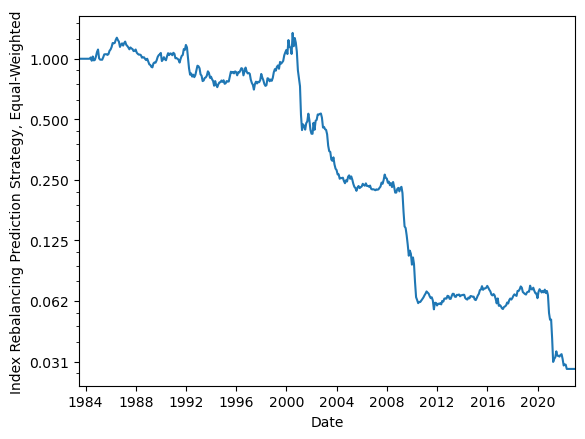

In [183]:
statistican.nav_plot()
statistican.output_stats()